In [53]:
import pandas as pd
from tinydb import TinyDB, Query
import matplotlib.pyplot as plt
import numpy as np
db = TinyDB('data/db/transactions.json')
analysis=pd.DataFrame(db.all())

In [54]:
%load_ext autoreload
%autoreload 2
import reportlab_api as rapi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import datetime
import dateutil.relativedelta

## Global variables
month = '2020-02-01'
#month = '2019-12-01'
d = datetime.datetime.strptime(month, "%Y-%m-%d")
months_ago_1 = (d - dateutil.relativedelta.relativedelta(months=1)).strftime("%Y-%m-%d")
months_ago_2 = (d - dateutil.relativedelta.relativedelta(months=2)).strftime("%Y-%m-%d")
months_ago_3 = (d - dateutil.relativedelta.relativedelta(months=3)).strftime("%Y-%m-%d")

date = d.date()
month_name = ['Januari','Februari','Mars','April','Maj','Juni','Juli','Augusti','September','Oktober','November','December']
month_name = str(month_name[date.month-1]) + ' ' + str(date.year)

min_transaction_date_month = min(analysis[analysis['budget_month']==month]['transaction_date_str'])
max_transaction_date_month = max(analysis[analysis['budget_month']==month]['transaction_date_str'])
min_transaction_date_month_ago_1 = min(analysis[analysis['budget_month']==months_ago_1]['transaction_date_str'])
max_transaction_date_month_ago_1 = max(analysis[analysis['budget_month']==months_ago_1]['transaction_date_str'])

## Setup Dataframes

In [56]:
def transaction_type(row):
#    print(row['level_1_category'])
    if row['level_1_category'] in ['Salary','Benefits']:
        return 'Income'
    elif row['level_1_category'] in ['Savings']:
        return 'Savings'
    else:
        return 'Expense'

analysis['transaction_type'] = analysis.apply(transaction_type, axis=1)

In [57]:
def changeability(row):
#    print(row['level_1_category'])
    if (row['transaction_type']=='Expense'):
        if ((row['level_2_category'] in ['Utilities','Rent','Mortgage & Interest','Insurance & Fees','Media & IT']) | (row['transaction_description'] in ['Betalning BG 5010-9198 Volkswagen F','Betalning BG 732-2548 FASTIGHETSBOL'])):
            return 'fixed'
        else:
            return 'variable'
    else:
        '-'

analysis['changeability'] = analysis.apply(changeability, axis=1)

In [58]:
## Try to remove

#import matplotlib.pyplot as plt
##pd.set_option('display.max_rows', 100)
#income_df = analysis[(analysis['level_1_category'].isin(['Salary','Benefits']))]
#income_tot = income_df.pivot_table(columns='budget_month',values=['transaction_amount'],aggfunc='sum').fillna(0).T #.plot(kind='barh',figsize=(10,10)).
#income_tot.columns=['income']
#
#savings_df = analysis[(analysis['level_1_category'].isin(['Savings']))]
#savings_tot = savings_df.pivot_table(columns='budget_month',values=['transaction_amount'],aggfunc='sum').fillna(0).T #.plot(kind='barh',figsize=(10,10)).
#savings_tot.columns=['savings']
#savings_tot.loc[:,'savings'] = savings_tot.loc[:,'savings']*-1
#
#expence_df = analysis[~(analysis['level_1_category'].isin(['Salary','Benefits'])) & (analysis['level_1_category']!='Savings')]
#expence_df.sort_values('transaction_date_str')[expence_df['budget_month']==month]['transaction_amount'].cumsum()
#expence_df.loc[:,'transaction_amount'] = expence_df.loc[:,'transaction_amount']*-1
#
#expences_tot = expence_df.pivot_table(columns='budget_month',values=['transaction_amount'],aggfunc='sum').fillna(0).T
#expences_tot.columns=['expense']
#

## Create Plots

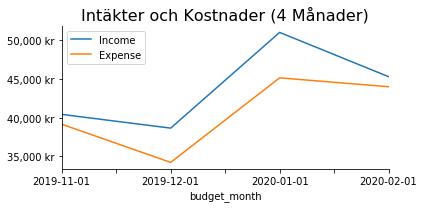

In [59]:
# DF
tot = analysis.pivot_table(index=['budget_month'],columns=['transaction_type'],values=['transaction_amount'],aggfunc='sum').fillna(0)
tot.columns = tot.columns.get_level_values(1)
tot.columns.name = ''
tot.loc[:,'Expense'] = tot.loc[:,'Expense']*-1 # change sign of expences, needs to be done after grouping due to reimbursements
tot = tot[(tot.index>= months_ago_3) & (tot.index<= month)]
# plot
fig1, ax1 = plt.subplots(figsize=(6,3))
plt.title('Intäkter och Kostnader (4 Månader)', fontsize=16)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
import matplotlib.ticker as mtick
fmt = '{x:,.0f} kr'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 

tot[['Income','Expense']].plot(ax=ax1)
plt.tight_layout()
plt.show()
fig1.savefig('./plots/expence_report_'+month.replace('-','_')+'.png',transparent=True)


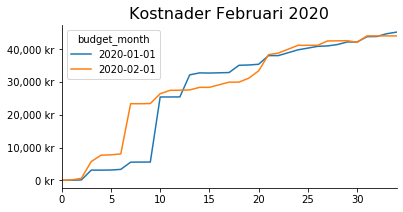

In [60]:
## DF
#cumsum_graph_df = analysis[(analysis['budget_month']==month) & (analysis['transaction_type']=='Expense')].sort_values('transaction_date_str')
#cumsum_graph_df['cumulative_transaction_amount'] = cumsum_graph_df[cumsum_graph_df['budget_month']==month]['transaction_amount'].cumsum()
#cumsum_graph_df = cumsum_graph_df[['transaction_date_str','cumulative_transaction_amount']]
#cumsum_graph_df['transaction_date_str'] = pd.to_datetime(cumsum_graph_df['transaction_date_str'])
#cumsum_graph_df.columns=['Datum','Utgifter']
#cumsum_graph_df.loc[:,'Utgifter'] = cumsum_graph_df.loc[:,'Utgifter']*-1
#cumsum_graph_df=cumsum_graph_df.set_index('Datum')
##Plot
#fig1, ax1 = plt.subplots(figsize=(6,3))
#ax1.spines['right'].set_visible(False)
#ax1.spines['top'].set_visible(False)
#cumsum_graph_df.plot(ax=ax1)
#ax1.get_legend().remove()
#
#import matplotlib.ticker as mtick
#fmt = '{x:,.0f} kr'
#tick = mtick.StrMethodFormatter(fmt)
#ax1.yaxis.set_major_formatter(tick) 
#
#plt.title('Kostnader ' + month_name, fontsize=16)
#
#plt.show()
#fig1.savefig('./plots/cumulative_'+month.replace('-','_')+'.png')
#

csum_graph_df = analysis[(analysis['budget_month'].isin([month,months_ago_1])) & (analysis['transaction_type']=='Expense')].sort_values('transaction_date_str')

def days_since_salary(row):
    if row['budget_month']==month:
        return datetime.datetime.strptime(row['transaction_date_str'], "%Y-%m-%d") - datetime.datetime.strptime(min_transaction_date_month, "%Y-%m-%d")
    if row['budget_month']==months_ago_1:
        return datetime.datetime.strptime(row['transaction_date_str'], "%Y-%m-%d") - datetime.datetime.strptime(min_transaction_date_month_ago_1, "%Y-%m-%d")
    
csum_graph_df['days_since_salary'] = csum_graph_df.apply(days_since_salary,axis=1)
csum_graph_plot_df = csum_graph_df.pivot_table(index=['days_since_salary'],columns='budget_month',values=['transaction_amount'],aggfunc='sum').fillna(0)
csum_graph_plot_df.columns = csum_graph_plot_df.columns.get_level_values(1)
csum_graph_plot_df  =csum_graph_plot_df.cumsum().abs()
csum_graph_plot_df.index = [int(i[:-5]) for i in csum_graph_plot_df.index.astype(str)]
fig1, ax1 = plt.subplots(figsize=(6,3))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
csum_graph_plot_df.plot(ax=ax1)

import matplotlib.ticker as mtick
fmt = '{x:,.0f} kr'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 

plt.title('Kostnader ' + month_name, fontsize=16)

plt.show()
fig1.savefig('./plots/cumulative_'+month.replace('-','_')+'.png')




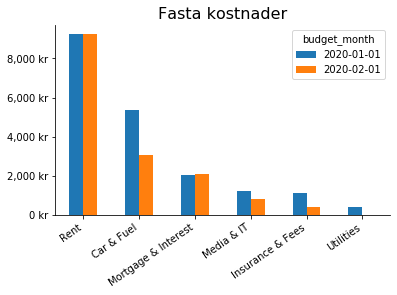

In [61]:
# DF
fixed_costs_2m = analysis[
    ( (analysis['budget_month']==month) | (analysis['budget_month']==months_ago_1) ) 
    & (analysis['changeability']=='fixed')]
fixed_costs_2m_plot_data = fixed_costs_2m.pivot_table(index=['level_2_category'],columns='budget_month',values=['transaction_amount'],aggfunc='sum').fillna(0)
fixed_costs_2m_plot_data.columns = fixed_costs_2m_plot_data.columns.get_level_values(1)
fixed_costs_2m_plot_data.loc[:,[month,months_ago_1]] = fixed_costs_2m_plot_data.loc[:,[month,months_ago_1]]*-1
fixed_costs_2m_plot_data = fixed_costs_2m_plot_data.sort_values(by=month,ascending=False)

# Fig
fig1, ax1 = plt.subplots(figsize=(6,3.5))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fixed_costs_2m_plot_data.plot(kind='bar',ax=ax1)
#ax1.get_legend().remove()

import matplotlib.ticker as mtick
fmt = '{x:,.0f} kr'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 

plt.title('Fasta kostnader', fontsize=16) #+ month_name, fontsize=16)


ax1.xaxis.set_label_text("")
ax1.set_xticklabels(list(fixed_costs_2m_plot_data.T.columns), rotation=35,ha='right')
plt.show()
fig1.tight_layout()
fig1.savefig('./plots/categories_fixed'+month.replace('-','_')+'.png')


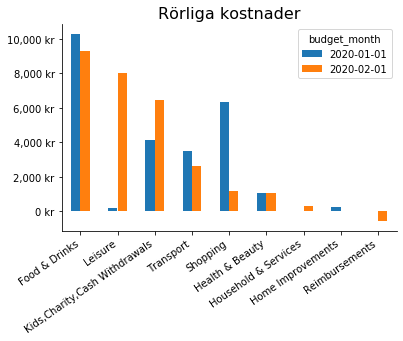

In [62]:
# DF
variable_costs_2m = analysis[
    ( (analysis['budget_month']==month) | (analysis['budget_month']==months_ago_1) ) 
    & (analysis['changeability']=='variable')]
variable_costs_2m_plot_data = variable_costs_2m.pivot_table(index=['level_1_category'],columns='budget_month',values=['transaction_amount'],aggfunc='sum').fillna(0)
variable_costs_2m_plot_data.columns = variable_costs_2m_plot_data.columns.get_level_values(1)
variable_costs_2m_plot_data.loc[:,[month,months_ago_1]] = variable_costs_2m_plot_data.loc[:,[month,months_ago_1]]*-1
variable_costs_2m_plot_data = variable_costs_2m_plot_data.sort_values(by=month,ascending=False)
as_list = variable_costs_2m_plot_data.index.tolist()
idx = as_list.index('Other')
as_list[idx] = ','.join([i for i in variable_costs_2m[variable_costs_2m['level_1_category']=='Other']['level_2_category'].unique()])
variable_costs_2m_plot_data.index = as_list


# Fig
fig1, ax1 = plt.subplots(figsize=(6,3.8))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
variable_costs_2m_plot_data.plot(kind='bar',ax=ax1)
#ax1.get_legend().remove()

import matplotlib.ticker as mtick
fmt = '{x:,.0f} kr'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 

plt.title('Rörliga kostnader', fontsize=16)# + month_name, fontsize=16)


ax1.xaxis.set_label_text("")
ax1.set_xticklabels(list(variable_costs_2m_plot_data.T.columns), rotation=35,ha='right')
plt.show()
fig1.tight_layout()
fig1.savefig('./plots/categories_variable'+month.replace('-','_')+'.png')


In [63]:
variable_costs_2m_plot_data = variable_costs_2m.pivot_table(index=['level_1_category'],columns='budget_month',values=['transaction_amount'],aggfunc='sum').fillna(0)
variable_costs_2m_plot_data.columns = variable_costs_2m_plot_data.columns.get_level_values(1)
variable_costs_2m_plot_data.loc[:,[month,months_ago_1]] = variable_costs_2m_plot_data.loc[:,[month,months_ago_1]]*-1
variable_costs_2m_plot_data = variable_costs_2m_plot_data.sort_values(by=month,ascending=False)
as_list = variable_costs_2m_plot_data.index.tolist()
idx = as_list.index('Other')
as_list[idx] = ','.join([i for i in variable_costs_2m[variable_costs_2m['level_1_category']=='Other']['level_2_category'].unique()])
variable_costs_2m_plot_data.index = as_list

In [64]:
## Summary Total Table
overview_table_df = analysis[(analysis['budget_month']==month) & (analysis['transaction_type'].isin(['Expense','Income']))].pivot_table(index=['transaction_type'],columns='budget_month',values=['transaction_amount'],aggfunc='sum').fillna(0)
overview_table_df.columns = overview_table_df.columns.get_level_values(0)
overview_table_df['transaction_amount'] = overview_table_df['transaction_amount'].astype(int)
overview_table_df = overview_table_df.append(pd.Series(overview_table_df.sum(numeric_only=True),name='Total'))
def sort_order(row):
    if row.name == 'Expense':
        return 1
    elif row.name == 'Income':
        return 0
    else:
        return 2
overview_table_df['sort_order'] = overview_table_df.apply(sort_order,axis=1)
overview_table_df = overview_table_df.sort_values(by='sort_order')[['transaction_amount']].reset_index()[['transaction_type', 'transaction_amount']]
overview_table_df.columns=['Totalt','']
overview_table_df['Totalt'] = pd.Series(['Inkomst','Kostnad','Summa'])

In [65]:
## Summary Total Table
changeability_df = analysis[(analysis['budget_month']==month)].pivot_table(index=['changeability'],columns='budget_month',values=['transaction_amount'],aggfunc='sum').fillna(0)
changeability_df = changeability_df
changeability_df.columns = changeability_df.columns.get_level_values(0)
changeability_df['transaction_amount'] = changeability_df['transaction_amount'].astype(int)
changeability_df = changeability_df.append(pd.Series(changeability_df.sum(numeric_only=True),name='Total'))
changeability_df = changeability_df.reset_index()
changeability_df.columns=['Kostnad','']
changeability_df['Kostnad'] = pd.Series(['Fasta','Rörliga','Summa'])

### Prepare data for PDF

In [66]:
##Summary text
num_transactions = len(analysis[analysis['budget_month']==month]) ## remove?
start_date = min(analysis[analysis['budget_month']==month]['transaction_date_str'])
end_date = max(analysis[analysis['budget_month']==month]['transaction_date_str'])




## data for texts

In [67]:
analysis[(analysis['budget_month']=='2020-01-01') & (analysis['transaction_type']=='Savings')]

,transaction_id,transaction_date_str,transaction_amount,transaction_formated_description,level_1_category,level_2_category,category_level,budget_month,account_number,account_name,transaction_type,transaction_description,changeability
5,190802654720258083715949356925666560192,2019-12-23,-6353.03,Överföring 1849 28 72179,Savings,Savings,3,2020-01-01,18492079010,Gemensamt Transaktionskonto,Savings,Överföring 1849 28 72179,None
16,248082622369756347890604970472800240170,2019-12-30,-500.00,Autogiro Dreams,Savings,Savings,3,2020-01-01,33009107283104,Julia Personkonto,Savings,Autogiro Dreams,None


In [68]:
# summary
total_savings = int(sum(analysis[(analysis['budget_month']>='2020-01-01') & (analysis['transaction_type']=='Savings')]['transaction_amount'])*-1)
summary_text = 'Totalt sparande under 2020 är ' + str(total_savings) + ' kr. '

## Groceries
groceries_df = analysis[(analysis['level_2_category']=='Groceries') & (analysis['budget_month']==month)].copy()
def get_groceries(row):
    if 'willys' in row['transaction_formated_description'].lower():
        return 'willys'
    elif 'danviksklippans livs' in row['transaction_formated_description'].lower():
        return 'danviksklippan'
    else:
        return 'other'
groceries_df['groceires_type'] = groceries_df.apply(get_groceries, axis=1)
willys = int(sum(groceries_df[groceries_df['groceires_type']=='willys']['transaction_amount'])*-1)
danviksklippan = int(sum(groceries_df[groceries_df['groceires_type']=='danviksklippan']['transaction_amount'])*-1)
groceries_tot = int(sum(groceries_df['transaction_amount'])*-1)
restaurant = analysis[(analysis['level_2_category'].isin(['Coffee & Snacks','Restaurants'])) & (analysis['budget_month']==month)].copy()
r_text = int(sum(restaurant[restaurant['level_2_category'] == 'Restaurants']['transaction_amount'])*-1)
fika_text = int(sum(restaurant[restaurant['level_2_category'] == 'Coffee & Snacks']['transaction_amount'])*-1)
groceries_text = 'Under ' + month_name + ' har vi spenderat ' + str(groceries_tot) + ' kr på matvaror, varav ' + str(willys) + ' kr är på Willys och ' + str(danviksklippan) + ' kr på Danviksklppan.'
restaurant_text = ' På Restaurang har vi spenderat ' + str(r_text) + ' kr och på fika ' + str(fika_text) +' kr.'
food_text = groceries_text + restaurant_text


# Create PDF

In [69]:
from reportlab.lib.pagesizes import letter, landscape
from reportlab.platypus import Image
from reportlab.lib.units import cm
d = rapi.Document(month_name + '.pdf',pagesize=landscape(letter))
p = rapi.Page("page1",1
      ,document=d
      ,x_padding=1.5
      ,y_padding=1
     )

#l = rapi.Logo('testName',path='./plots/logo.png',width=100,height=50,position='bottom-right', page=p, padding=1.5)

r1 = rapi.Row(name="header1",height=2.5,level=1,page=p)
r_rubriker = rapi.Row(name="h2",height=1,level=2,page=p)
r2 = rapi.Row(name="row2",height=3,level=3,page=p)
r3 = rapi.Row(name="header3",height=15,level=4,page=p)
#columns
c11 = rapi.Column(name="r1c1",width=15,level=1,row=r1,show_boundry=0)
c_rubriker_1 = rapi.Column(name="rubrik1",width=12,level=1,row=r_rubriker,show_boundry=0)
c_rubriker_2 = rapi.Column(name="rubrik2",width=12,level=2,row=r_rubriker,show_boundry=0,padding_left=1.5)
c21 = rapi.Column(name="r2c1",width=6,level=1,row=r2,show_boundry=0)
c22 = rapi.Column(name="r2c2",width=6,level=3,row=r2,show_boundry=0)
c23 = rapi.Column(name="r2c1",width=6,level=4,row=r2,show_boundry=0,padding_left=1.5)
c24 = rapi.Column(name="r2c2",width=6,level=6,row=r2,show_boundry=0)

c31 = rapi.Column(name="r3c1",width=12,level=1,row=r3,show_boundry=0)
c32 = rapi.Column(name="r3c2",width=12,level=2,row=r3,show_boundry=0,padding_left=1.5)

## Paragraphs data

headline_text = 'Budgetuppföljning - ' + str(month_name)
period_text = start_date + ' - ' + end_date

rapi.ColParagraph('test',c11,headline_text,text_settings={'fontSize':24})

rapi.ColParagraph('test',c_rubriker_1,'Översikt',text_settings={'fontSize':18}) 
rapi.ColParagraph('test',c_rubriker_2,'Fasta och rörliga kostnader',text_settings={'fontSize':18}) 

rapi.ColSpacer('spacer',c11,1, 20)
rapi.ColParagraph('test',c11,period_text,text_settings={'fontSize':12})

rapi.ColSpacer('spacer',c21,1, 8)
rapi.ColParagraph('test',c21,summary_text,text_settings={'fontSize':8})
t1 = rapi.ColTable('overview',c22,df=overview_table_df,totals_line=True,altering_colors=True,formating=['','kr'])

rapi.ColSpacer('spacer',c23,1, 8)
rapi.ColParagraph('test',c23,food_text,text_settings={'fontSize':8})
t1 = rapi.ColTable('overview',c24,df=changeability_df,totals_line=True,altering_colors=True,formating=['','kr'])

im = rapi.ColImage('bild1',c31,'./plots/expence_report_'+month.replace('-','_')+'.png',width=10*cm)
rapi.ColSpacer('spacer',c31,1, 28)
im = rapi.ColImage('bild2',c31,'./plots/cumulative_'+month.replace('-','_')+'.png',width=10*cm)

im = rapi.ColImage('bild1',c32,'./plots/categories_fixed'+month.replace('-','_')+'.png',width=10*cm)
im = rapi.ColImage('bild1',c32,'./plots/categories_variable'+month.replace('-','_')+'.png',width=10*cm)

d.save()

page 1 complete


In [37]:
analysis[analysis['transaction_description'].isin(['Överföring 1849 28 72179'])]

,transaction_id,transaction_date_str,transaction_amount,transaction_formated_description,level_1_category,level_2_category,category_level,budget_month,account_number,account_name,transaction_type,transaction_description,changeability
15,130385913002047341358517695832698065165,2020-01-24,-2195.52,Överföring 1849 28 72179,Savings,Savings,3,2020-02-01,18492079010,Gemensamt Transaktionskonto,Savings,Överföring 1849 28 72179,None
16,190802654720258083715949356925666560192,2019-12-23,-6353.03,Överföring 1849 28 72179,Savings,Savings,3,2020-01-01,18492079010,Gemensamt Transaktionskonto,Savings,Överföring 1849 28 72179,None


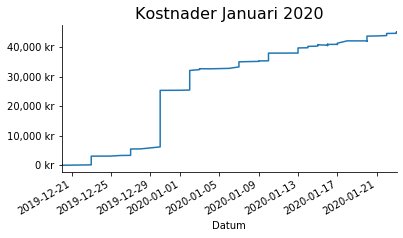

In [116]:
cumsum_graph_df = analysis[(analysis['budget_month']==month) & (analysis['transaction_type']=='Expense')].sort_values('transaction_date_str')
cumsum_graph_df['cumulative_transaction_amount'] = cumsum_graph_df[cumsum_graph_df['budget_month']==month]['transaction_amount'].cumsum()
cumsum_graph_df = cumsum_graph_df[['transaction_date_str','cumulative_transaction_amount']]
cumsum_graph_df['transaction_date_str'] = pd.to_datetime(cumsum_graph_df['transaction_date_str'])
cumsum_graph_df.columns=['Datum','Utgifter']
cumsum_graph_df.loc[:,'Utgifter'] = cumsum_graph_df.loc[:,'Utgifter']*-1
cumsum_graph_df=cumsum_graph_df.set_index('Datum')
#Plot
fig1, ax1 = plt.subplots(figsize=(6,3))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
cumsum_graph_df.plot(ax=ax1)
ax1.get_legend().remove()

import matplotlib.ticker as mtick
fmt = '{x:,.0f} kr'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 

plt.title('Kostnader ' + month_name, fontsize=16)

plt.show()
fig1.savefig('./plots/cumulative_'+month.replace('-','_')+'.png')


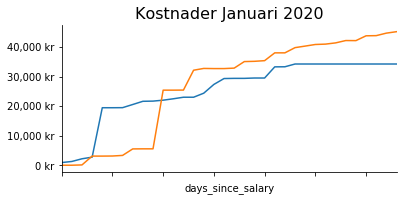

In [117]:
csum_graph_df = analysis[(analysis['budget_month'].isin([month,months_ago_1])) & (analysis['transaction_type']=='Expense')].sort_values('transaction_date_str')

def days_since_salary(row):
    if row['budget_month']==month:
        return datetime.datetime.strptime(row['transaction_date_str'], "%Y-%m-%d") - datetime.datetime.strptime(min_transaction_date_month, "%Y-%m-%d")
    if row['budget_month']==months_ago_1:
        return datetime.datetime.strptime(row['transaction_date_str'], "%Y-%m-%d") - datetime.datetime.strptime(min_transaction_date_month_ago_1, "%Y-%m-%d")
    
csum_graph_df['days_since_salary'] = csum_graph_df.apply(days_since_salary,axis=1)
csum_graph_plot_df = csum_graph_df.pivot_table(index=['days_since_salary'],columns='budget_month',values=['transaction_amount'],aggfunc='sum').fillna(0)
csum_graph_plot_df.columns = csum_graph_plot_df.columns.get_level_values(1)
csum_graph_plot_df  =csum_graph_plot_df.cumsum().abs()
fig1, ax1 = plt.subplots(figsize=(6,3))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
csum_graph_plot_df.plot(ax=ax1)
ax1.get_legend().remove()

import matplotlib.ticker as mtick
fmt = '{x:,.0f} kr'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 

plt.title('Kostnader ' + month_name, fontsize=16)

plt.show()
fig1.savefig('./plots/cumulative_'+month.replace('-','_')+'.png')



In [119]:

    
    
    
#    'willys' in row['transaction_formated_description'].lower():
#        return 'willys'
#    elif 'danviksklippans livs' in row['transaction_formated_description'].lower():
#        return 'danviksklippan'
#    else:
#        return 'other'

In [120]:
csum_graph_df['transaction_date_str']

442    2019-11-25
182    2019-11-25
183    2019-11-25
506    2019-11-25
441    2019-11-25
          ...    
540    2020-01-22
115    2020-01-23
282    2020-01-23
500    2020-01-23
11     2020-01-23
Name: transaction_date_str, Length: 270, dtype: object

In [121]:
min(csum_graph_df[csum_graph_df['budget_month']==month]['transaction_date_str'])
max(csum_graph_df[csum_graph_df['budget_month']==month]['transaction_date_str'])

'2020-01-23'

In [122]:
analysis[(analysis['budget_month']==month) & (analysis['transaction_type']=='Expense')].sort_values('transaction_date_str')

,transaction_id,transaction_date_str,transaction_amount,transaction_formated_description,level_1_category,level_2_category,category_level,budget_month,account_number,account_name,transaction_type,transaction_description,changeability
315,261008530544367371237586331953866088829,2019-12-20,-225.55,Coop Hammarby Sjosta,Food & Drinks,Groceries,3,2020-01-01,18492079010,Gemensamt Transaktionskonto,Expense,Kortköp 191217 COOP HAMMARBY SJOSTA,variable
316,241953347783814408981793150362517972237,2019-12-20,-70.70,Danviksklippans Livs,Food & Drinks,Groceries,3,2020-01-01,18492079010,Gemensamt Transaktionskonto,Expense,Kortköp 191218 DANVIKSKLIPPANS LIVS,variable
158,284291474280932638688775478749970225291,2019-12-20,-29.00,Swish EMIL BERN,Food & Drinks,Bars,3,2020-01-01,33008712091415,Filip Personkonto,Expense,Swish betalning EMIL BERN,variable
52,2845613365990130675148068823274277965,2019-12-20,50.00,Swish Anders Tarandi,Food & Drinks,Bars,3,2020-01-01,33008712091415,Filip Personkonto,Expense,Swish inbetalning Anders Tarandi,variable
53,48251172239481695297382915947777605127,2019-12-20,49.00,Swish EMIL BERN,Food & Drinks,Bars,3,2020-01-01,33008712091415,Filip Personkonto,Expense,Swish inbetalning EMIL BERN,variable
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,283873466054483130217943863929177689273,2020-01-22,-50.00,FACEBK *Treskablinol,Leisure,Hobbies,3,2020-01-01,18492079010,Gemensamt Transaktionskonto,Expense,Kortköp 200120 FACEBK *Treskablinol,variable
500,329457268784290211407244161467727922491,2020-01-23,-54.00,Espresso House 290,Food & Drinks,Coffee & Snacks,3,2020-01-01,18492079010,Gemensamt Transaktionskonto,Expense,Kortköp 200121 ESPRESSO HOUSE 290,variable
282,191144809565882052171614405229952430859,2020-01-23,-394.70,Ica Supermarket Medb,Food & Drinks,Groceries,3,2020-01-01,18492079010,Gemensamt Transaktionskonto,Expense,Kortköp 200120 ICA SUPERMARKET MEDB,variable
115,219874194051024133284989045902504607597,2020-01-23,-90.00,Fotoaffärn I Sundsva,Other,Uncategorized,3,2020-01-01,18492079010,Gemensamt Transaktionskonto,Expense,Kortköp 200121 FOTOAFFÄRN I SUNDSVA,variable
